## Objective:
    Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset. 
## Dataset:
    The dataset contains historical exchange rate with each column representing a different currency rate over time. The first column indicates the date, and second column represent exchange rates USD to Australian Dollar.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')
import statsmodels.tsa.api as smt

## Part 1: Data Preparation and Exploration
    1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.
    2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
    3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

In [2]:
df=pd.read_csv('exchange_rate.csv',index_col='date',parse_dates=True)
df.head(20)

,Ex_rate
date,
01-01-1990 00:00,0.7855
02-01-1990 00:00,0.7818
03-01-1990 00:00,0.7867
04-01-1990 00:00,0.7860
05-01-1990 00:00,0.7849
06-01-1990 00:00,0.7866
07-01-1990 00:00,0.7886
08-01-1990 00:00,0.7910
09-01-1990 00:00,0.7939


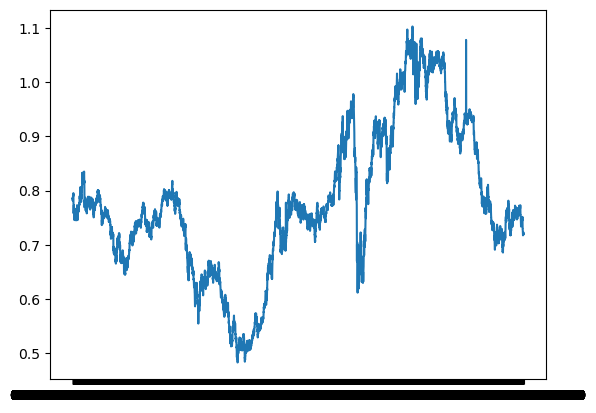

In [3]:
plt.plot(df)
plt.show()

In [4]:
df.index = pd.to_datetime(df.index, format="%d-%m-%Y %H:%M")

In [5]:
df.index = df.index.normalize()

In [6]:
model=seasonal_decompose(df['Ex_rate'],model='additive')

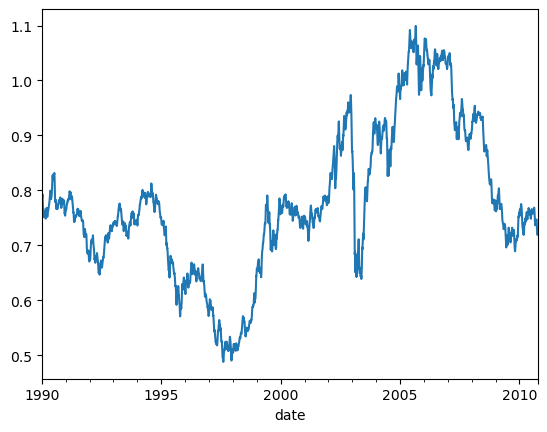

In [7]:
model.trend.plot()
plt.show()

<Axes: xlabel='date'>

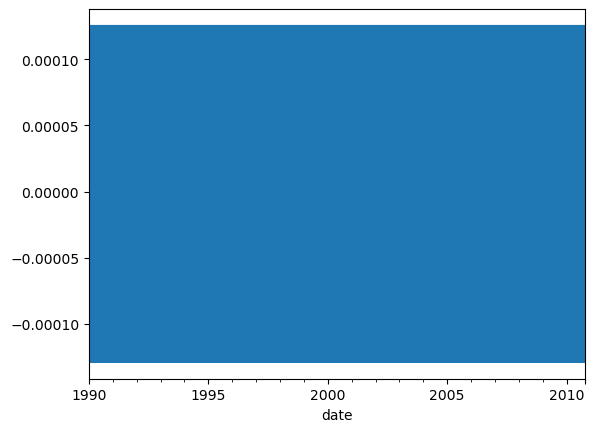

In [8]:
model.seasonal.plot()


<Axes: xlabel='date'>

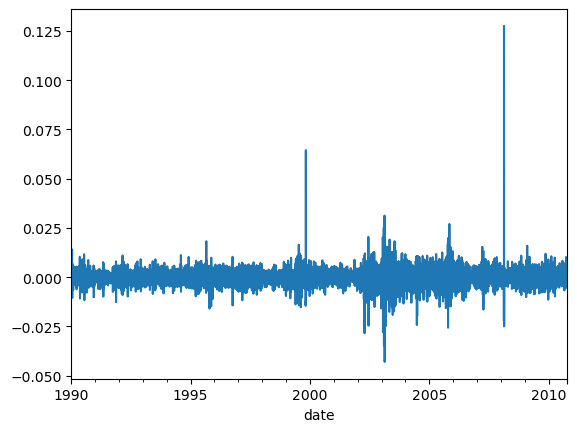

In [9]:
model.resid.plot()

## Part 2: Model Building - ARIMA
     1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.
    2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
    3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
    4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.


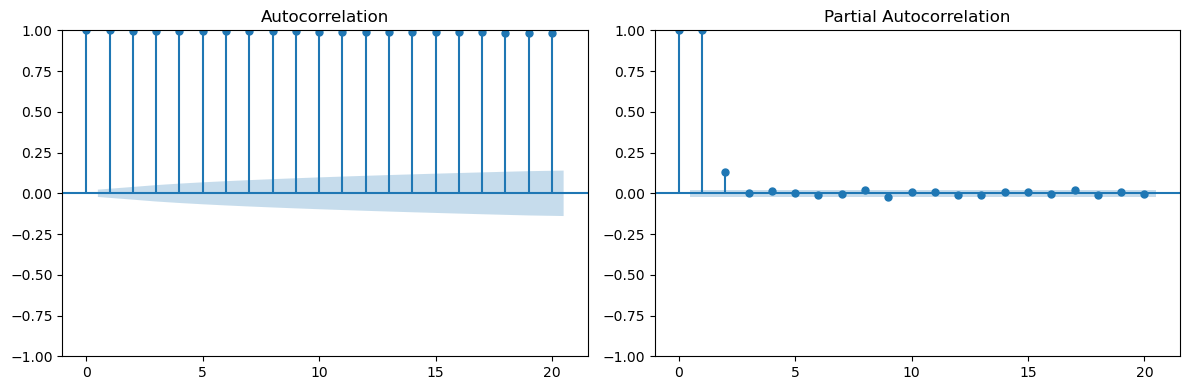

In [10]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(df['Ex_rate'], lags=20, ax=axes[0])
smt.graphics.plot_pacf(df['Ex_rate'], lags=20, ax=axes[1])
plt.tight_layout()

In [11]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Ex_rate'], order=(20,1,2))

In [12]:
result=model.fit()

In [13]:
df['predicted']=result.predict()

In [14]:
forecast=result.forecast(20)
forecast

2010-10-11    0.720873
2010-10-12    0.720913
2010-10-13    0.721009
2010-10-14    0.720971
2010-10-15    0.721051
2010-10-16    0.721132
2010-10-17    0.721089
2010-10-18    0.721093
2010-10-19    0.721176
2010-10-20    0.721107
2010-10-21    0.721108
2010-10-22    0.721115
2010-10-23    0.721071
2010-10-24    0.721076
2010-10-25    0.721114
2010-10-26    0.721086
2010-10-27    0.721099
2010-10-28    0.721088
2010-10-29    0.721091
2010-10-30    0.721095
Freq: D, Name: predicted_mean, dtype: float64

In [15]:
df.head()

,Ex_rate,predicted
date,,
1990-01-01,0.7855,0.000000
1990-01-02,0.7818,0.785500
1990-01-03,0.7867,0.782290
1990-01-04,0.7860,0.786054
1990-01-05,0.7849,0.786138


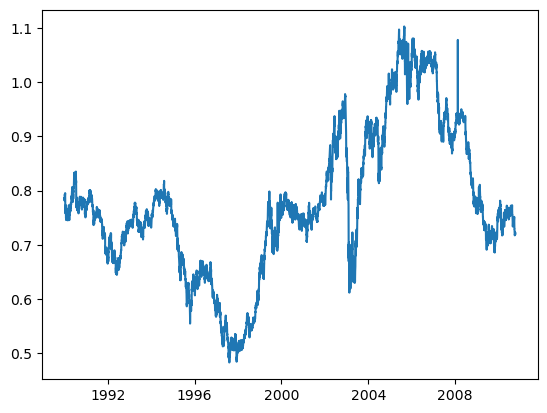

In [16]:
plt.plot(df['Ex_rate'],label='Original')

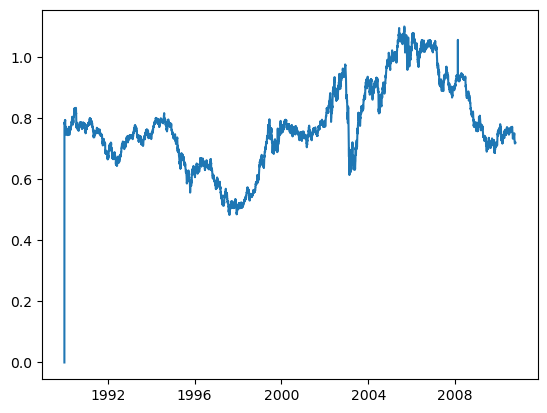

In [17]:
plt.plot(df['predicted'],label='Predicted')

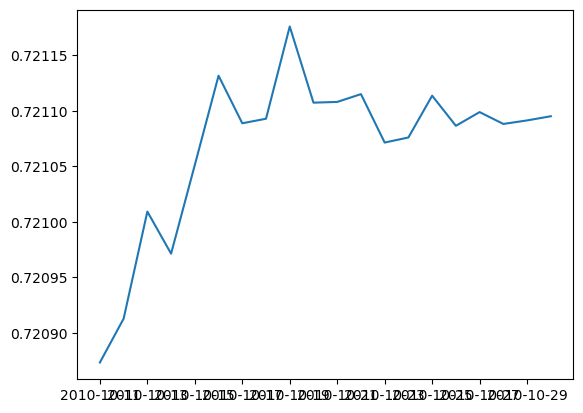

In [18]:
plt.plot(forecast,label='Forecast')

## Part 3: Model Building - Exponential Smoothing
    1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).
    2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.
    3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.


In [19]:
double= ExponentialSmoothing(df['Ex_rate'],trend='additive').fit(smoothing_level=0.5,smoothing_trend=0.7)

In [21]:
alpha_values = np.arange(0.1, 1.0, 0.1) 
beta_values  = np.arange(0.1, 1.0, 0.1)   

best_params = {}
best_mse = float('inf')        

for alpha in alpha_values:
    for beta in beta_values:
        try:
            model = ExponentialSmoothing(
                df['Ex_rate'],
                trend='add'
            ).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)

            y_pred = model.fittedvalues
            mse = mean_squared_error(df['Ex_rate'], y_pred)

            print(f"Alpha={alpha:.1f}, Beta={beta:.1f} --> MSE={mse:.4f}")

            if mse < best_mse:
                best_mse = mse
                best_params = {'smoothing_level': alpha, 'smoothing_slope': beta}

        except Exception as e:
            print(f"Skipped Alpha={alpha:.1f}, Beta={beta:.1f} due to error: {e}")
            continue

print("\nBest Parameters Found:")
print(best_params)
print(f"Best MSE: {best_mse:.4f}")

Alpha=0.1, Beta=0.1 --> MSE=0.0001
Alpha=0.1, Beta=0.2 --> MSE=0.0001
Alpha=0.1, Beta=0.3 --> MSE=0.0002
Alpha=0.1, Beta=0.4 --> MSE=0.0002
Alpha=0.1, Beta=0.5 --> MSE=0.0002
Alpha=0.1, Beta=0.6 --> MSE=0.0002
Alpha=0.1, Beta=0.7 --> MSE=0.0002
Alpha=0.1, Beta=0.8 --> MSE=0.0002
Alpha=0.1, Beta=0.9 --> MSE=0.0001
Alpha=0.2, Beta=0.1 --> MSE=0.0001
Alpha=0.2, Beta=0.2 --> MSE=0.0001
Alpha=0.2, Beta=0.3 --> MSE=0.0001
Alpha=0.2, Beta=0.4 --> MSE=0.0001
Alpha=0.2, Beta=0.5 --> MSE=0.0001
Alpha=0.2, Beta=0.6 --> MSE=0.0001
Alpha=0.2, Beta=0.7 --> MSE=0.0001
Alpha=0.2, Beta=0.8 --> MSE=0.0001
Alpha=0.2, Beta=0.9 --> MSE=0.0001
Alpha=0.3, Beta=0.1 --> MSE=0.0001
Alpha=0.3, Beta=0.2 --> MSE=0.0001
Alpha=0.3, Beta=0.3 --> MSE=0.0001
Alpha=0.3, Beta=0.4 --> MSE=0.0001
Alpha=0.3, Beta=0.5 --> MSE=0.0001
Alpha=0.3, Beta=0.6 --> MSE=0.0001
Alpha=0.3, Beta=0.7 --> MSE=0.0001
Alpha=0.3, Beta=0.8 --> MSE=0.0001
Alpha=0.3, Beta=0.9 --> MSE=0.0001
Alpha=0.4, Beta=0.1 --> MSE=0.0000
Alpha=0.4, Beta=0.2 

In [23]:
double= ExponentialSmoothing(df['Ex_rate'],trend='additive').fit(smoothing_level=0.8,smoothing_trend=0.1)

In [24]:
double_pred= double.fittedvalues
double_fore= double.forecast(20)

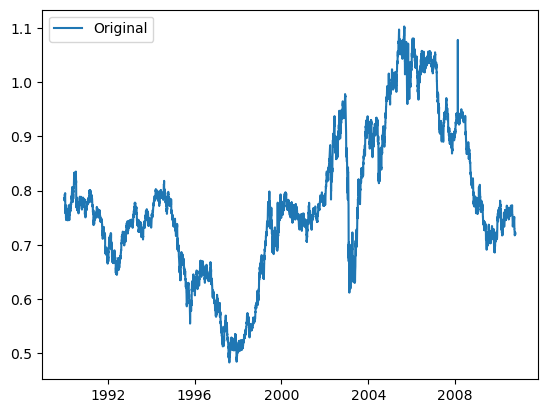

In [25]:
plt.plot(df['Ex_rate'],label='Original')

plt.legend()

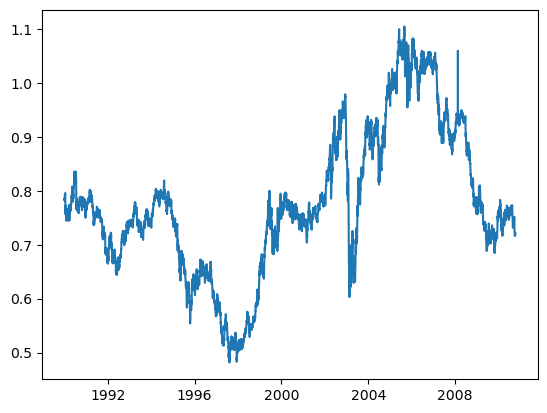

In [26]:
plt.plot(double_pred,label='Pred')


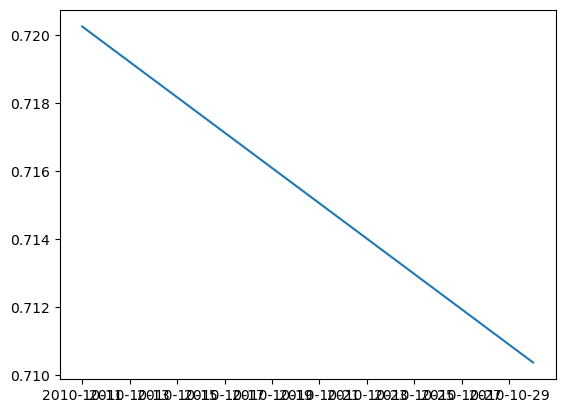

In [27]:
plt.plot(double_fore,label='forecast')

## Part 4: Evaluation and Comparison
     1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
     2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
     3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.


In [28]:
double_mse= mean_squared_error(df['Ex_rate'],double_pred)
arrima_mse=mean_squared_error(df['Ex_rate'],df['predicted'])
print('Double_MSE:',double_mse,',','Arrima_mse:',arrima_mse)

Double_MSE: 3.776457479517326e-05 , Arrima_mse: 0.00011718424321724179


In [29]:
double_mae= mean_absolute_error(df['Ex_rate'],double_pred)
arrima_mae=mean_absolute_error(df['Ex_rate'],df['predicted'])
print('Double_MAE:',double_mae,',','Arrima_mae:',arrima_mae)

Double_MAE: 0.003857168674958096 , Arrima_mae: 0.003800249486784702


In [30]:
double_mape= mean_absolute_percentage_error(df['Ex_rate'],double_pred)
arrima_mape=mean_absolute_percentage_error(df['Ex_rate'],df['predicted'])
print('Double_MAPE:',double_mape,',','Arrima_mse:',arrima_mape)

Double_MAPE: 0.0050334070115821555 , Arrima_mse: 0.004956088764693306


2.
## Advantages:
            Double_EXP_Smoothing is used to catch both the level and trend.In Arima we can handle the non_stationary data by calculating the rolling statistical parameters.
## Limitations:
            In doule_exp_smoothing we cannot able to capture seasonal data.While in Arima it is required a careful choosing of the parameters (p,d,q) which requires a more recurive implementation of the model

3.
## Conclusion
            From the above results we conclude that arima outperformed double_exp_smoothing.The ability of arima to handle auto_correlation and non _stationarity allowed it to capture the data well.